# Portfolios Pesos Iguais, MPT e Paridade de Risco

In [1]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
import funcoes as f
import warnings; 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
periodos = 60
oos = 1

stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date')
benchmark = stock_prices['BOVA11.SA']
stock_prices.drop('BOVA11.SA', axis=1, inplace=True)

## Portfolio de Pesos Iguais (EW)

Utilizo o portfolio de pesos iguais, por ele ser usado como ponto de partida das otimizações.

O portfolio de pesos é a forma mais simples de alocação de ativos, sendo o peso de cada ativo dado pela equação: 

$$ w = \frac{1}{n} $$

Sendo $ n $ o numero de ativos que compõe a carteira

Os portfolios de pesos iguais tendem a ser menos arriscados, do que portfolios cap-weighted (como o ibovespa por exemplo), devido a um maior numero de constituintes efetivos (ENC) dado pela equação:
$$ ENC = (\sum^N_{i=1}w^2_i)^{-1} $$ 

Sendo:  
$N$ o número de ativos que compõe o portfolio  
$w$ o peso de cada ativo

O ENC mede quão bem diversificado um portfólio é, dados os pesos alocados.  
Como vemos abaixo o Indice Bovespa tem um ENC de 19, porem se fosse alocado pela estratégia de pesos iguais teria como ENC de 84*, que é o numero de constituintes 


<h6> *Utilizando a composição do ibovespa de agosto de 2023, que continham 87 tickers, mas 84 empresas 

Benchmark Done
EW Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Adjusted Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
EW,18.39,24.21,0.37775,0.35249,0.65291,-6.43,-35.37,-0.74366,6.37206,10.69,13.76
BOVA11,10.06,23.81,0.05930,0.05876,0.22390,-7.87,-37.65,-0.85778,6.79857,11.25,14.75


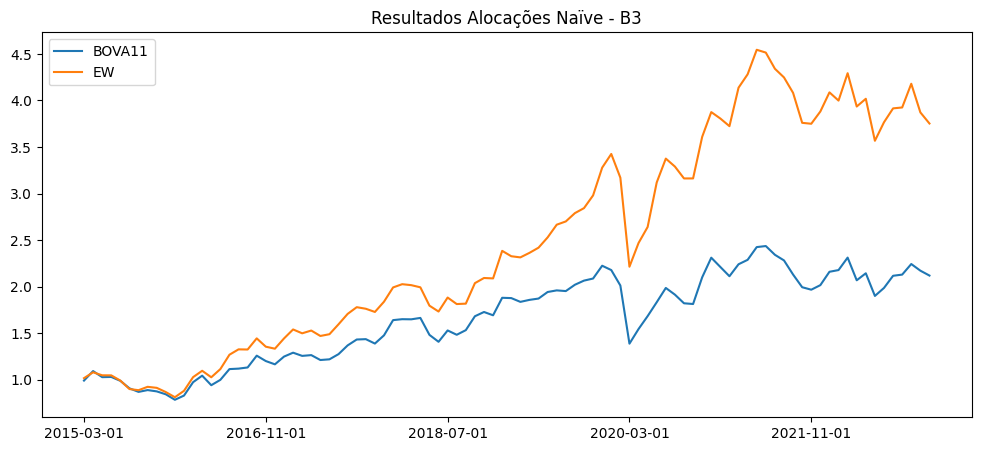

In [3]:
bova = f.returns(benchmark);print('Benchmark Done')
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')

ew_results = pd.DataFrame(
    {
    "BOVA11": bova[rets_ew.index.min():],
     "EW": rets_ew['rets'], 
    }
)

rfr = f.annualize_rets(
    f.get_taxa_juros(rets_ew.index.min(),rets_ew.index.max())
)[0]


(1+ew_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naïve - B3");
f.summary_stats(ew_results,rfr).sort_values('Sharpe Ratio', ascending=False)

## Teoria Moderna de Portfolio (MPT)

a MPT, introduzida por Harry Markowitz na década de 1950, fornece uma maneira sistemática para a construção de portfólios, utilizando a diversificação de ativos, busca auxiliar o investidor a maximizar os retornos para um determinado nivel de risco, ou minimizar o risco para um determinado nivel de retorno.

O conceito central da MPT é a fronteira Eficiente, que respresenta o conjunto de portfólios.  
Esses portfólios na Fronteira Eficiente são consideradas ótimas pois oferecem o maior retorno possível para um determinado nível de risco ou o menor risco possível para um determinado nível de retorno.

A MPT tem sofrida criticas ao longo do tempo, devido aos suas suposições e sua construção. 
entre as criticas pode-se destacar:  
Suposição de distribuição normal dos retornos dos ativos, algo que raramente é visto na realidade.  
Estabilidade das correlações: que não acontece, principalmente em momentos de crise, causando um subestimação do risco.  
Suposição que todos investidores tomam decisões com base nos retornos e nos riscos esperados, quando na realidade, eles apresentam vieses comportamentais.  
Erros de estimativa, estimativas de retorno são extremamente sensiveis á mudanças, pequenas variações nos dados de entrada, podem entregar alocações significativamente diferentes, com isso causando falta de confiança na capacidade da MPT em entregar alocações com alta precisão.  

https://www.math.hkust.edu.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf


## Portfólio Máximo Indice de Sharpe (MSR)

MSR 1/n Done
MSR 50% Done
MSR 100% Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Adjusted Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
MSR 1/n,19.17,19.31,0.51152,0.51041,0.86953,-3.98,-24.46,1.14481,12.15121,4.53,9.00
MSR 50%,15.60,21.85,0.30015,0.31413,0.59750,-5.01,-24.76,2.01517,17.44717,3.02,10.91
MSR 100%,12.83,22.77,0.17527,0.18066,0.38046,-6.45,-24.77,1.61373,15.79153,4.53,12.93
BOVA11,10.06,23.81,0.05930,0.05876,0.22390,-7.87,-37.65,-0.85778,6.79857,11.25,14.75


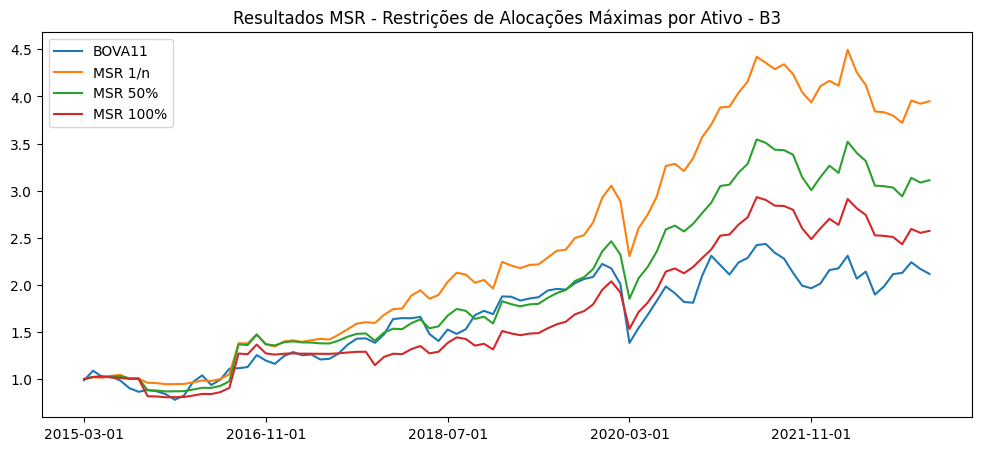

In [4]:
rets_msr_1n = f.pipeline(stock_prices, periodos, oos, algo=f.weight_msr);print('MSR 1/n Done')
rets_msr_50 = f.pipeline(stock_prices, periodos, oos, algo=f.weight_msr, max_allocation=.50);print('MSR 50% Done')
rets_msr_100 = f.pipeline(stock_prices, periodos, oos, algo=f.weight_msr, max_allocation=1);print('MSR 100% Done')

msr_results = pd.DataFrame(
    {
     "BOVA11": bova[rets_ew.index.min():],
     "MSR 1/n": rets_msr_1n['rets'], 
     "MSR 50%": rets_msr_50['rets'], 
     "MSR 100%": rets_msr_100['rets'], 
    }
)

(1+msr_results).cumprod().plot(figsize=(12,5), title="Resultados MSR - Restrições de Alocações Máximas por Ativo - B3");
f.summary_stats(msr_results,rfr).sort_values('Sharpe Ratio', ascending=False)

### Portfólio Mínima Variancia Global (GMV)

GMV 1/n Done
GMV 50% Done
GMV 100% Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Adjusted Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
GMV 1/n,20.08,21.46,0.4992,0.49874,0.88608,-4.77,-27.37,0.95024,10.70418,5.69,9.68
GMV 50%,20.08,21.46,0.4992,0.49874,0.88608,-4.77,-27.37,0.95024,10.70418,5.69,9.68
GMV 100%,20.08,21.46,0.4992,0.49874,0.88608,-4.77,-27.37,0.95024,10.70418,5.69,9.68
BOVA11,10.06,23.81,0.0593,0.05876,0.22390,-7.87,-37.65,-0.85778,6.79857,11.25,14.75


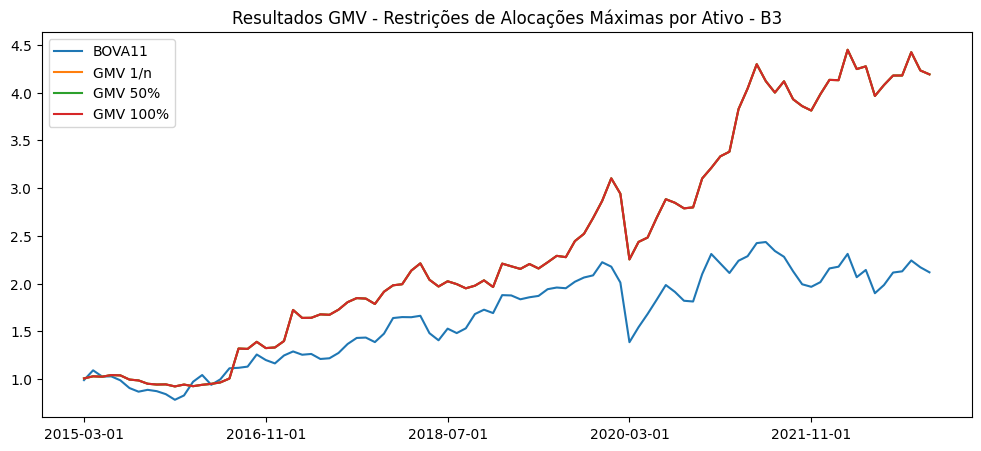

In [5]:
rets_gmv_1n = f.pipeline(stock_prices, periodos, oos, algo=f.weight_gmv);print('GMV 1/n Done')
rets_gmv_50 = f.pipeline(stock_prices, periodos, oos, algo=f.weight_gmv, max_allocation=.50);print('GMV 50% Done')
rets_gmv_100 = f.pipeline(stock_prices, periodos, oos, algo=f.weight_gmv, max_allocation=1);print('GMV 100% Done')

gmv_results = pd.DataFrame(
    {
     "BOVA11": bova[rets_ew.index.min():],
     "GMV 1/n": rets_gmv_1n['rets'], 
     "GMV 50%": rets_gmv_50['rets'], 
     "GMV 100%": rets_gmv_100['rets'], 
    }
)

(1+gmv_results).cumprod().plot(figsize=(12,5), title="Resultados GMV - Restrições de Alocações Máximas por Ativo - B3");
f.summary_stats(gmv_results,rfr).sort_values('Sharpe Ratio', ascending=False)

## Portfólio de Paridade de Risco (ERC)

Semelhante ao Portfólio de Pesos Iguais, o Portfolio ERC busca equalizar as contribuições dos ativos, mas dessa vez considerando o inverso da volatilidade que eles aprensentam, atráves de equação:

$$ w_i = \frac{\frac{1}{\sigma i}}{\sum^N_{j=1}\frac{1}{\sigma j}} $$
Sendo:
$w_i$ é peso do ativo $i$  
nominador é a volatilidade do ativo  
denominador é soma das volatilidades dos ativos da carteira

Esse método de alocação, popularizado pelo fundo All Weather de Ray Dalio e Bob Prince


Benchmark Done
ERC Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Adjusted Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
ERC,21.18,21.75,0.53955,0.49991,0.8735,-4.61,-30.44,-0.35836,6.40010,8.66,11.62
BOVA11,10.06,23.81,0.05930,0.05876,0.2239,-7.87,-37.65,-0.85778,6.79857,11.25,14.75


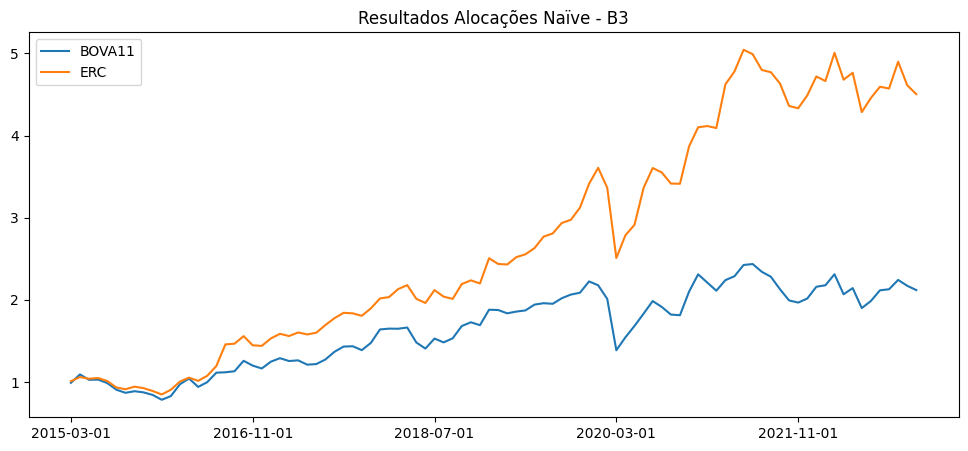

In [6]:
bova = f.returns(benchmark);print('Benchmark Done')
rets_erc = f.pipeline(stock_prices, periodos, oos, algo=f.weight_erc);print('ERC Done')

erc_results = pd.DataFrame(
    {
    "BOVA11": bova[rets_ew.index.min():],
     "ERC": rets_erc['rets'],
    }
)

(1+erc_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naïve - B3");
f.summary_stats(erc_results,rfr).sort_values('Sharpe Ratio', ascending=False)

### Comparação Portfólios Simples

In [7]:
simple_portfolios_results = pd.DataFrame(
    {
    "BOVA11": bova[rets_ew.index.min():],
     "EW": rets_ew['rets'], 
     "GMV": rets_gmv_1n['rets'], 
     "MSR": rets_msr_1n['rets'], 
     "ERC": rets_erc['rets'],
    }
)


simple_portfolios_results.corr()

,BOVA11,EW,GMV,MSR,ERC
BOVA11,1.000000,0.949759,0.598440,0.596107,0.862739
EW,0.949759,1.000000,0.678777,0.647131,0.935967
GMV,0.598440,0.678777,1.000000,0.841968,0.825866
MSR,0.596107,0.647131,0.841968,1.000000,0.820051
ERC,0.862739,0.935967,0.825866,0.820051,1.000000


,Annualized Return,Annualized Vol,Sharpe Ratio,Adjusted Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
ERC,21.18,21.75,0.53955,0.49991,0.87350,-4.61,-30.44,-0.35836,6.40010,8.66,11.62
MSR,19.17,19.31,0.51152,0.51041,0.86953,-3.98,-24.46,1.14481,12.15121,4.53,9.00
GMV,20.08,21.46,0.49920,0.49874,0.88608,-4.77,-27.37,0.95024,10.70418,5.69,9.68
EW,18.39,24.21,0.37775,0.35249,0.65291,-6.43,-35.37,-0.74366,6.37206,10.69,13.76
BOVA11,10.06,23.81,0.05930,0.05876,0.22390,-7.87,-37.65,-0.85778,6.79857,11.25,14.75


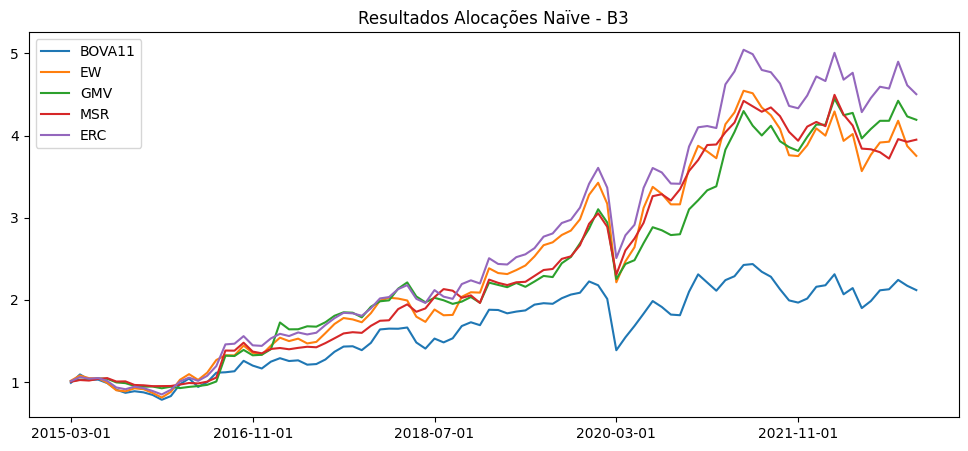

In [8]:
(1+simple_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naïve - B3");
f.summary_stats(simple_portfolios_results,rfr).sort_values('Sharpe Ratio', ascending=False)